# Clustering the Physical Activities for a Subject in the "Moderately Active" Group
Among the 183 subjects, we classified them into three categories based on their daily average steps:
* Inactive: daily average about 1 step.
* Moderately Active: daily average about 4 steps.
* Highly Active: daily average between 7-9 steps

In this notebook, we cluster the activities for a subject in the "Moderately Active" category.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 9
import datetime as datetime
from dateutil.parser import parse

## Load and Parse the data into Time Series
The individual subjects data have been extracted and stored in a separated folder. This subject data is stored in a file "medium1.csv".

In [2]:
dateparse = lambda d: parse(d)
df = pd.read_csv("patients_data/analyses/medium1.csv", parse_dates = \
                 ['Datetime'], index_col = "Datetime", date_parser=dateparse)

### What are the unique dates in this subject's timeline? 

In [3]:
np.unique(df.index.date)

array([datetime.date(2016, 6, 21), datetime.date(2016, 6, 22),
       datetime.date(2016, 6, 23), datetime.date(2016, 6, 24),
       datetime.date(2016, 6, 25), datetime.date(2016, 6, 26),
       datetime.date(2016, 6, 27), datetime.date(2016, 6, 28),
       datetime.date(2016, 6, 29), datetime.date(2016, 6, 30),
       datetime.date(2016, 7, 1), datetime.date(2016, 7, 2),
       datetime.date(2016, 7, 3), datetime.date(2016, 7, 4),
       datetime.date(2016, 7, 5), datetime.date(2016, 7, 6),
       datetime.date(2016, 7, 7), datetime.date(2016, 7, 8),
       datetime.date(2016, 7, 9), datetime.date(2016, 7, 10),
       datetime.date(2016, 7, 11), datetime.date(2016, 7, 12),
       datetime.date(2016, 7, 13)], dtype=object)

### What is the earlist time and latest time in the timeline?

In [4]:
print(np.min(df.index))
print ('-' * 10)
print(np.max(df.index))

2016-06-21 09:14:00
----------
2016-07-13 14:48:00


### How many records in total for this patient?

In [5]:
df = df.iloc[:, 2:]
df.shape

(32013, 15)

### Take a look at the data in several sample records:

In [6]:
df.sample(5)

,ACTDT,Day,Week,Time,Hour,Minute,Steps,Lux,YCnt,XCnt,ZCnt,Calories,VMU,Wear,WearSens
Datetime,,,,,,,,,,,,,,,
2016-06-27 13:03:00,06/27/2016,7.0,1.0,13:03:00,13,3,0,NaN,877,550,1374,0.878271,1720.321191,True,1
2016-06-25 22:50:00,06/25/2016,5.0,1.0,22:50:00,22,50,0,NaN,0,0,0,0.000000,0.000000,False,1
2016-07-11 16:54:00,07/11/2016,21.0,3.0,16:54:00,16,54,0,NaN,321,294,734,0.202624,853.365689,True,1
2016-07-07 11:24:00,07/07/2016,17.0,3.0,11:24:00,11,24,0,NaN,1070,564,1607,1.269043,2011.329162,True,1
2016-07-07 02:29:00,07/07/2016,17.0,3.0,2:29:00,2,29,0,NaN,374,57,812,0.236079,895.806341,True,1


### In terms of steps, how do the minute-by-minute activties and daily average activities look like?

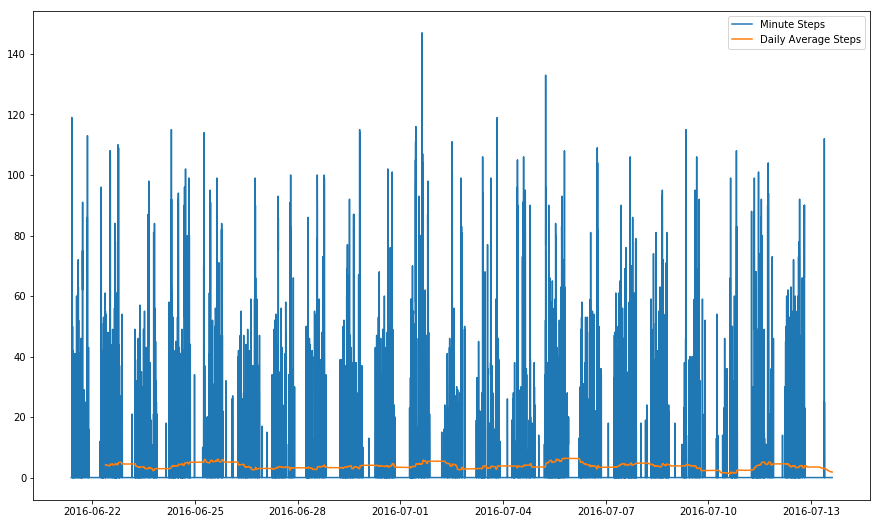

In [7]:
plt.figure(figsize = (15, 9))
plt.plot(df['Steps'], label = "Minute Steps")
plt.plot(df['Steps'].rolling(1440).mean(), label = "Daily Average Steps")
plt.legend(loc='best')

### How do the hourly average activities look like?

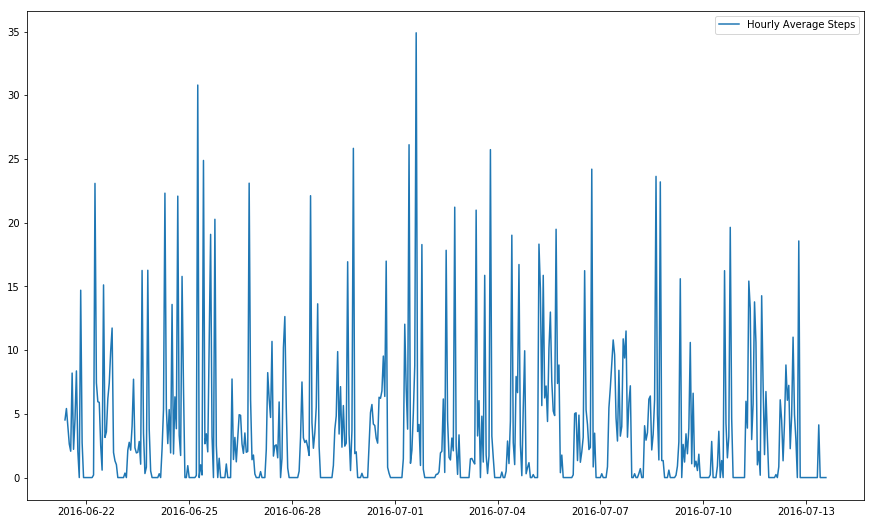

In [8]:
ts_hourly = df['Steps'].resample(rule="H").mean()
plt.plot(ts_hourly, label = "Hourly Average Steps")
plt.legend()

### How do the 15-minute average activities look like?

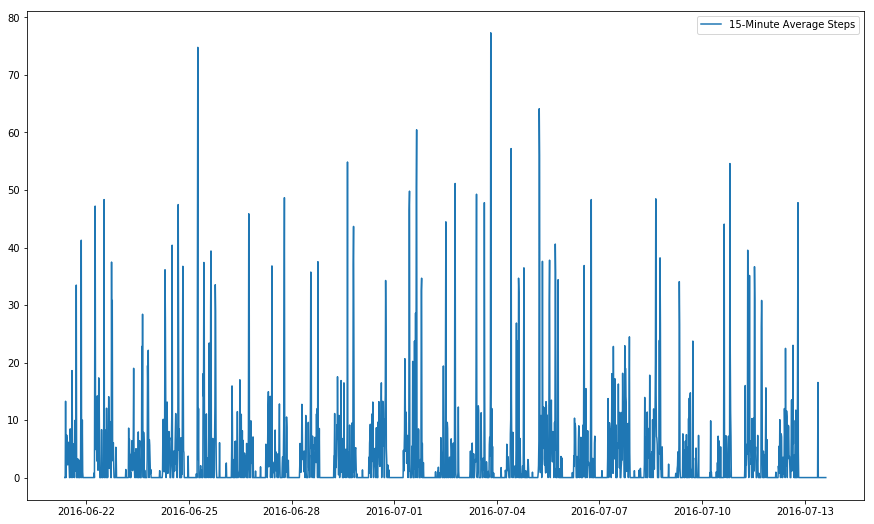

In [9]:
ts_quarterly = df['Steps'].resample('15T').mean()
plt.plot(ts_quarterly, label = "15-Minute Average Steps")
plt.legend()

### In terms of steps, how do the average activities change in a day (0:00-23:00)?

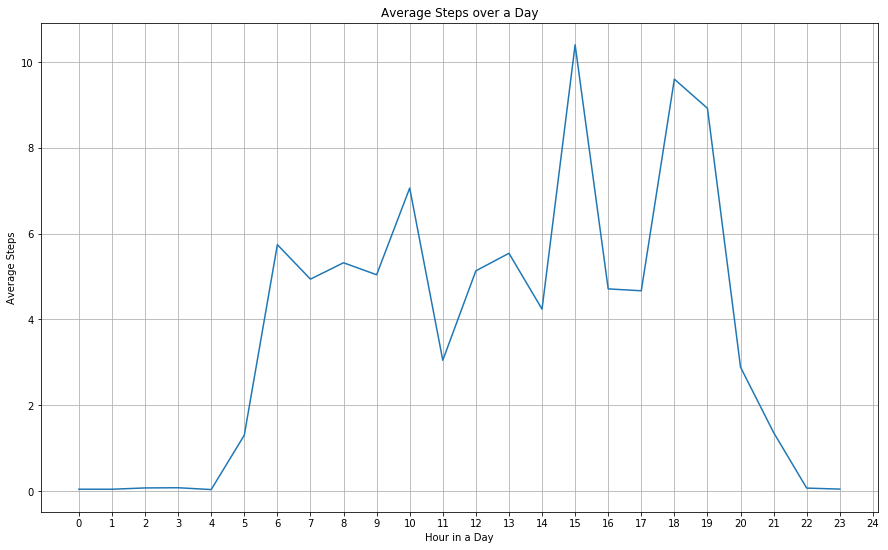

In [10]:
by_time = df[['Steps', 'Hour']].groupby('Hour').mean()
plt.plot(by_time)
plt.title("Average Steps over a Day")
plt.xticks(np.arange(25))
plt.xlabel("Hour in a Day")
plt.ylabel("Average Steps")
plt.grid()

#### As an interesting observation, this subject was active in every hour of a day on average. 

### OK, how does the boxplot of all the steps look like over all the hours in a day?

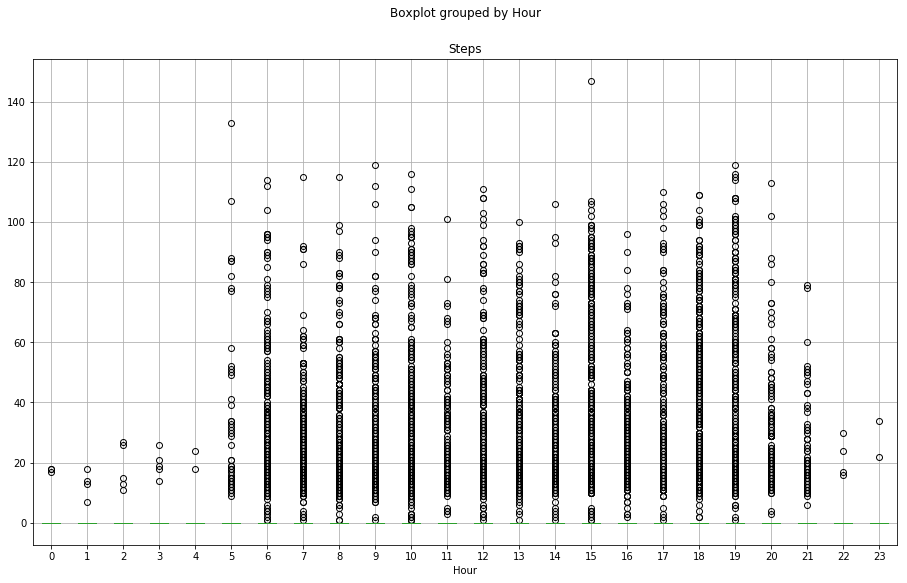

In [11]:
df.boxplot(column = 'Steps', by = 'Hour', figsize = (15, 9))

#### Again, this subject was active in every hour. However, in many hour points, the data points look like "outliers". It seems that the subject was inactive in most of the minutes in an hour.

### How do the activities in hours look iike if we factor the data by the wearSens field?

WearSens Specification:
- 0 = Non-Wear
- 1 = Wear
- 2 = Calibrating (the wear sensor calibrates for 10 seconds after it is unplugged from a docking station)
- 3 = Device is plugged into docking station

In [12]:
df['WearSens'].value_counts()

1    29321
0     1465
3     1227
Name: WearSens, dtype: int64

#### This subject either wore the monitor or not wore. 

In [13]:
box_data = df[['Steps', 'Hour', 'WearSens']]

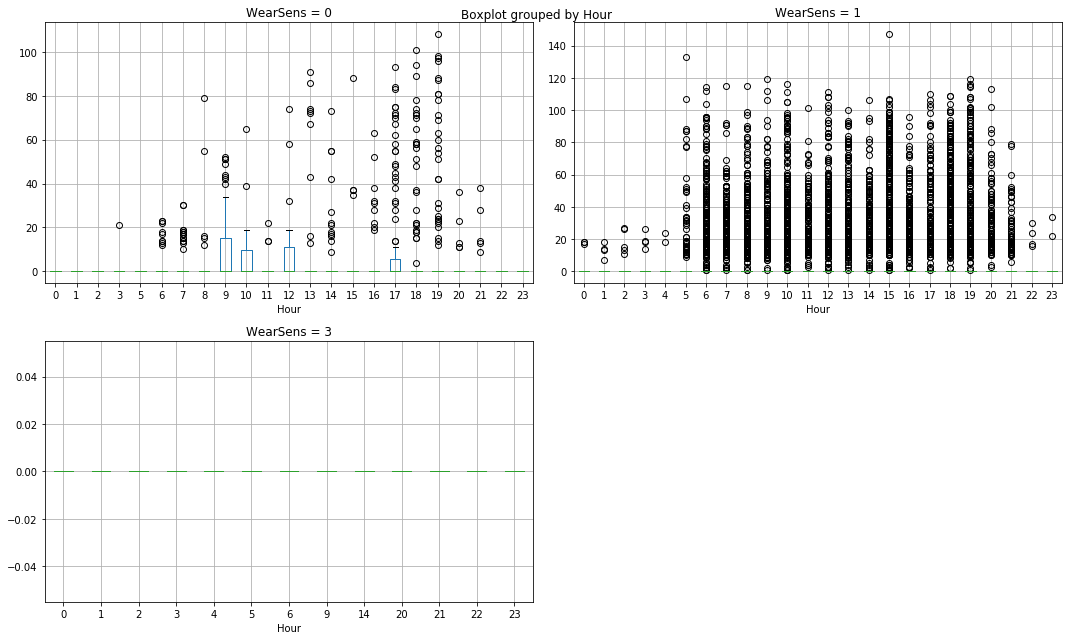

In [14]:
fig = plt.figure(figsize = (15, 9))
ax1 = fig.add_subplot(2, 2, 1)
box_data[box_data['WearSens'] == 0].boxplot(column = 'Steps', by = 'Hour', ax = ax1)
ax1.set_title("WearSens = 0")
ax2 = fig.add_subplot(2, 2, 2)
box_data[box_data['WearSens'] == 1].boxplot(column = 'Steps', by = 'Hour', ax = ax2)
ax3 = fig.add_subplot(2, 2, 3)
box_data[box_data['WearSens'] == 3].boxplot(column = 'Steps', by = 'Hour', ax = ax3)

ax2.set_title("WearSens = 1")
ax3.set_title("WearSens = 3")

plt.tight_layout()

### OK, for the most active hour at 15:00, how did the subject move in each minute when wearing the monitor?

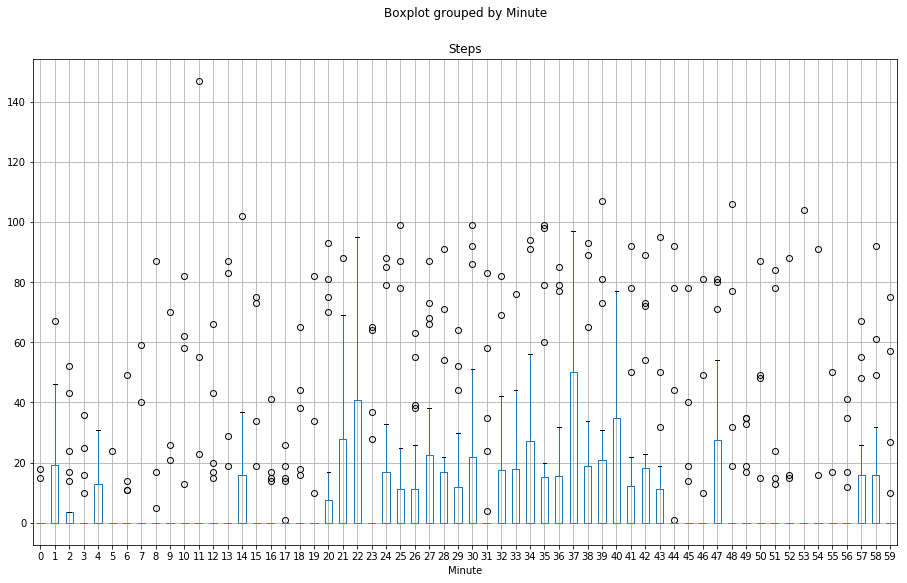

In [15]:
hour15 = df[df['Hour'] == 15]
hour15_wear1 = hour15[hour15.WearSens  == 1]
hour15_wear1.boxplot(column = "Steps", by = "Minute", figsize = (15, 9))

### Over the total 32013-minute records, how long did the subject wear the monitor?

In [16]:
df['WearSens'].value_counts()

1    29321
0     1465
3     1227
Name: WearSens, dtype: int64

#### The subject wore the monitor most of the time: 29321/32013.

### For each hour, what is the percentage of no activities (0 steps) on average?

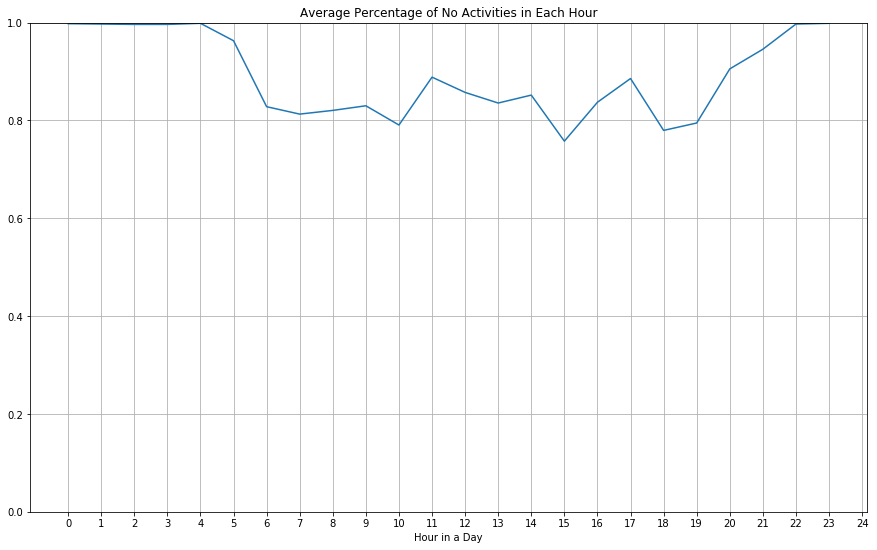

In [17]:
zero_perc = lambda g: (g == 0).sum() / g.shape[0]

plt.plot(df[['Steps', 'Hour']].groupby("Hour").agg(zero_perc))
plt.ylim((0,1))
plt.title("Average Percentage of No Activities in Each Hour")
plt.xlabel("Hour in a Day")
plt.xticks(np.arange(25))
plt.grid()

### How do the activity patterns look like in terms of weekdays?

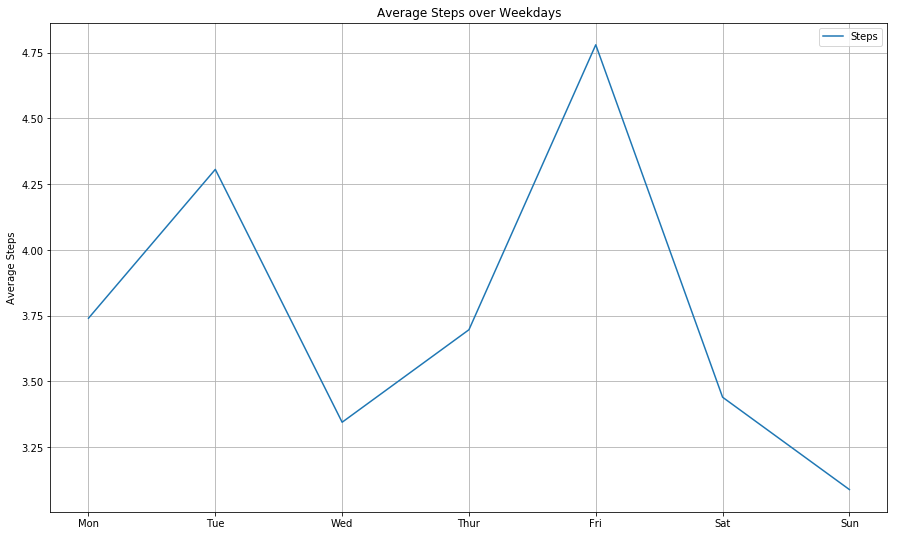

In [18]:
by_weekday = df[['Steps']].groupby(df.index.dayofweek).mean()
xticks = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
by_weekday.index = xticks
by_weekday.plot()
plt.xticks([0,1,2,3,4,5,6], xticks)
plt.ylabel("Average Steps")
plt.title("Average Steps over Weekdays")
plt.grid()

### How do the activity patterns look like in weekdays and weekend?

In [19]:
weekend = np.where(df.index.weekday < 5, 'weekday', 'weekend')
by_time = df.groupby([weekend, 'Hour']).mean()

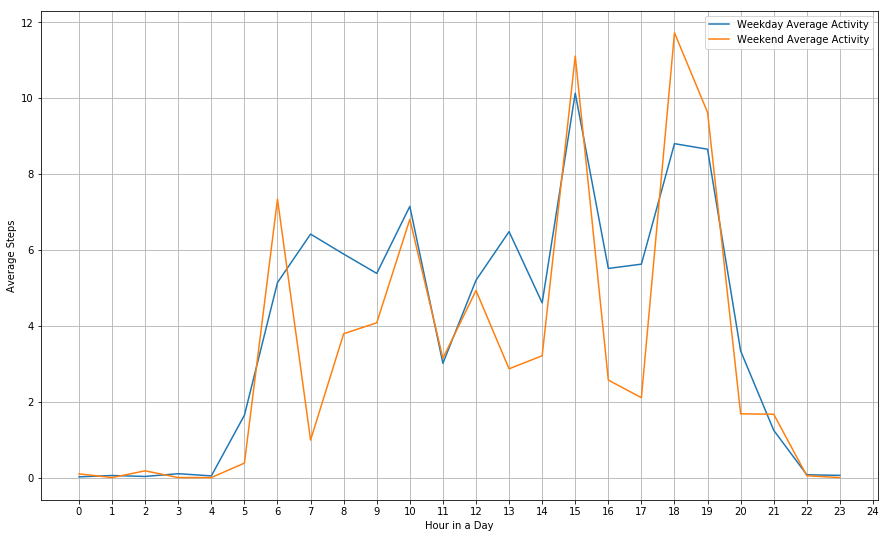

In [20]:
by_time.loc['weekday']['Steps'].plot(label = 'Weekday Average Activity')
by_time.loc['weekend']['Steps'].plot(label = "Weekend Average Activity")
plt.legend()
plt.xlabel("Hour in a Day")
plt.ylabel("Average Steps")
plt.xticks(np.arange(25))
plt.grid()

# Cluster the Activities by 15-minute means

In [130]:
df_15m = df.resample('15T').mean()
df_15m = df_15m[df_15m['WearSens'] == 1]

In [131]:
df_15m.sample(10)

,Day,Week,Hour,Minute,Steps,Lux,YCnt,XCnt,ZCnt,Calories,VMU,Wear,WearSens
Datetime,,,,,,,,,,,,,
2016-07-10 00:00:00,20.0,3.0,0.0,7.0,0.000000,NaN,37.400000,28.133333,14.533333,0.023608,51.510175,1.0,1.0
2016-07-09 18:45:00,19.0,3.0,18.0,52.0,0.000000,NaN,695.866667,302.200000,807.533333,0.784230,1141.116912,1.0,1.0
2016-07-04 03:30:00,14.0,2.0,3.0,37.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
2016-06-28 07:30:00,8.0,2.0,7.0,37.0,10.133333,NaN,2174.066667,2289.800000,2801.200000,3.008381,4271.228347,1.0,1.0
2016-06-26 18:30:00,6.0,1.0,18.0,37.0,2.333333,NaN,1228.666667,919.066667,1179.733333,1.331617,1970.811301,1.0,1.0
2016-07-11 19:00:00,21.0,3.0,19.0,7.0,4.600000,NaN,2620.466667,2708.800000,4162.733333,3.658630,5673.146479,1.0,1.0
2016-06-26 02:00:00,6.0,1.0,2.0,7.0,1.733333,NaN,257.666667,177.000000,292.800000,0.386747,436.184047,1.0,1.0
2016-07-12 23:00:00,22.0,NaN,23.0,7.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0
2016-07-08 12:30:00,18.0,3.0,12.0,37.0,3.666667,NaN,1359.266667,1207.133333,1587.866667,2.016722,2463.302076,1.0,1.0


In [132]:
pd.set_option('display.max_rows', 20)

In [133]:
df_15m.reset_index(inplace = True)

In [134]:
df_15m_data = df_15m[['Steps', 'YCnt', 'XCnt', 'ZCnt', 'Calories', 'VMU', 'WearSens']]

In [135]:
df_15m_data.shape

(1892, 7)

In [136]:
df_15m_data.index

RangeIndex(start=0, stop=1892, step=1)

In [137]:
df_15m_data = df_15m_data[df_15m_data.WearSens == 1]

In [138]:
df_15m_data.shape

(1892, 7)

In [139]:
df_15m_data.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891],
           dtype='int64', length=1892)

In [140]:
df_15m_data = df_15m_data.iloc[:, :-1]
df_15m_data.head()

,Steps,YCnt,XCnt,ZCnt,Calories,VMU
0,0.000000,734.230769,562.384615,617.461538,0.789704,1134.264328
1,13.266667,1811.733333,1510.266667,1884.933333,1.683214,3155.735116
2,0.000000,710.066667,405.533333,535.000000,0.738177,993.692255
3,3.933333,1384.666667,1235.000000,1503.866667,1.736702,2460.783340
4,7.400000,2357.933333,2264.000000,2722.933333,3.268968,4282.964538


In [141]:
df_15m_data.shape

(1892, 6)

In [142]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

In [143]:
scaler = StandardScaler().fit(df_15m_data)
scaled = scaler.transform(df_15m_data)
scaled.mean(axis = 0)

array([-0., -0., -0.,  0., -0.,  0.])

In [144]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [145]:
hclustering = linkage(scaled, 'ward')

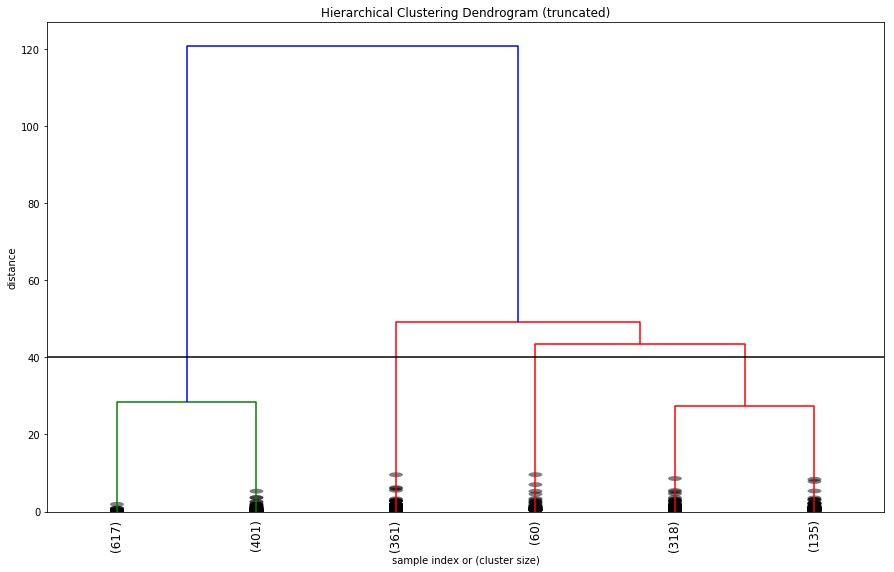

In [146]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    hclustering,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=6,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.axhline(40, c = 'k')
plt.show()

## Laying, Sitting, Standing, Walking

# K-Means Clustering and Visualization

In [117]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

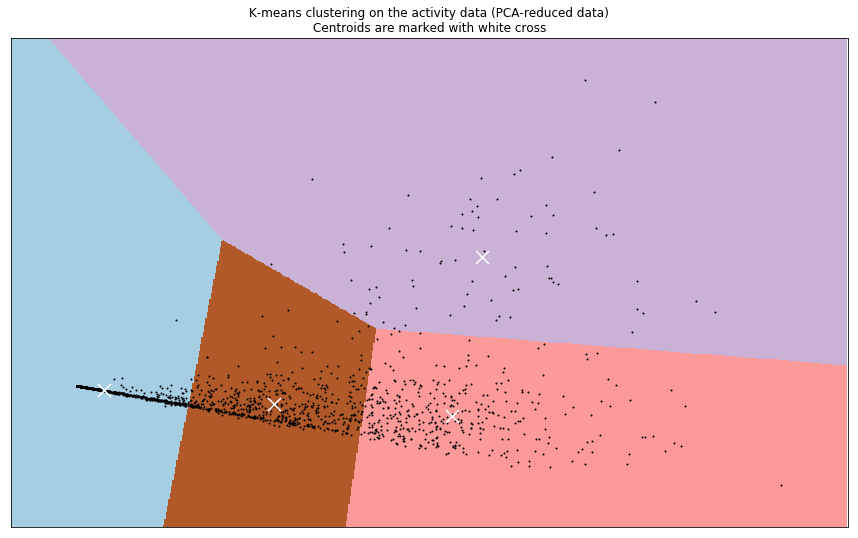

In [147]:
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(scaled)
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the activity data (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [148]:
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10)
kmeans.fit(scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [149]:
kmeans.cluster_centers_

array([[-0.437, -0.869, -0.864, -0.86 , -0.881, -0.876],
       [-0.09 ,  0.279,  0.259,  0.289,  0.275,  0.288],
       [ 4.123,  1.386,  1.358,  0.921,  1.319,  1.19 ],
       [ 0.364,  1.428,  1.453,  1.487,  1.478,  1.473]])

In [150]:
pd.value_counts(kmeans.labels_)

0    905
1    540
3    372
2     75
dtype: int64

In [151]:
centers = kmeans.cluster_centers_
scale_centers = scaler.inverse_transform(centers)

In [152]:
np.set_printoptions(precision=3, suppress = True)
scale_centers

array([[   0.104,  180.158,  135.55 ,  207.57 ,    0.189,  322.91 ],
       [   3.086, 1117.852, 1073.813, 1429.433,    1.477, 2169.595],
       [  39.296, 2021.938, 1991.93 , 2101.301,    2.641, 3600.705],
       [   6.992, 2056.285, 2071.053, 2703.317,    2.819, 4050.168]])

In [156]:
idx = ['Laying', 'Sitting', 'Walking', 'Standing']
cols = ['Steps', 'YCnt', 'XCnt', 'ZCnt', 'Calories', 'VMU']

In [157]:
clusters = pd.DataFrame(scale_centers, index = idx, columns = cols)

In [158]:
clusters

,Steps,YCnt,XCnt,ZCnt,Calories,VMU
Laying,0.103720,180.158413,135.550112,207.570234,0.189000,322.910419
Sitting,3.085556,1117.852469,1073.813210,1429.433210,1.477088,2169.594725
Walking,39.296000,2021.937778,1991.929778,2101.301333,2.640692,3600.705313
Standing,6.991935,2056.285125,2071.053047,2703.317025,2.818709,4050.168313


In [161]:
df_15m_data['label'] = kmeans.labels_
df_15m_data.head()

,Steps,YCnt,XCnt,ZCnt,Calories,VMU,label
0,0.000000,734.230769,562.384615,617.461538,0.789704,1134.264328,0
1,13.266667,1811.733333,1510.266667,1884.933333,1.683214,3155.735116,1
2,0.000000,710.066667,405.533333,535.000000,0.738177,993.692255,0
3,3.933333,1384.666667,1235.000000,1503.866667,1.736702,2460.783340,1
4,7.400000,2357.933333,2264.000000,2722.933333,3.268968,4282.964538,3


In [163]:
lab_act = {0:'Laying', 1:'Sitting', 2:'Walking', 3:'Standing'}
df_15m_data['activity'] = df_15m_data['label'].map(lab_act)

In [164]:
df_15m_data.head()

,Steps,YCnt,XCnt,ZCnt,Calories,VMU,label,activity
0,0.000000,734.230769,562.384615,617.461538,0.789704,1134.264328,0,Laying
1,13.266667,1811.733333,1510.266667,1884.933333,1.683214,3155.735116,1,Sitting
2,0.000000,710.066667,405.533333,535.000000,0.738177,993.692255,0,Laying
3,3.933333,1384.666667,1235.000000,1503.866667,1.736702,2460.783340,1,Sitting
4,7.400000,2357.933333,2264.000000,2722.933333,3.268968,4282.964538,3,Standing


In [165]:
df_15m['activity'] = df_15m_data['activity']
df_15m.head()

,Datetime,Day,Week,Hour,Minute,Steps,Lux,YCnt,XCnt,ZCnt,Calories,VMU,Wear,WearSens,activity
0,2016-06-21 09:15:00,1.0,1.0,9.0,22.538462,0.000000,NaN,734.230769,562.384615,617.461538,0.789704,1134.264328,1.0,1.0,Laying
1,2016-06-21 09:30:00,1.0,1.0,9.0,37.000000,13.266667,NaN,1811.733333,1510.266667,1884.933333,1.683214,3155.735116,1.0,1.0,Sitting
2,2016-06-21 09:45:00,1.0,1.0,9.0,52.000000,0.000000,NaN,710.066667,405.533333,535.000000,0.738177,993.692255,1.0,1.0,Laying
3,2016-06-21 10:00:00,1.0,1.0,10.0,7.000000,3.933333,NaN,1384.666667,1235.000000,1503.866667,1.736702,2460.783340,1.0,1.0,Sitting
4,2016-06-21 10:15:00,1.0,1.0,10.0,22.000000,7.400000,NaN,2357.933333,2264.000000,2722.933333,3.268968,4282.964538,1.0,1.0,Standing


In [197]:
act_groups = df_15m.groupby(['Hour', 'activity']).count()[['Steps']]

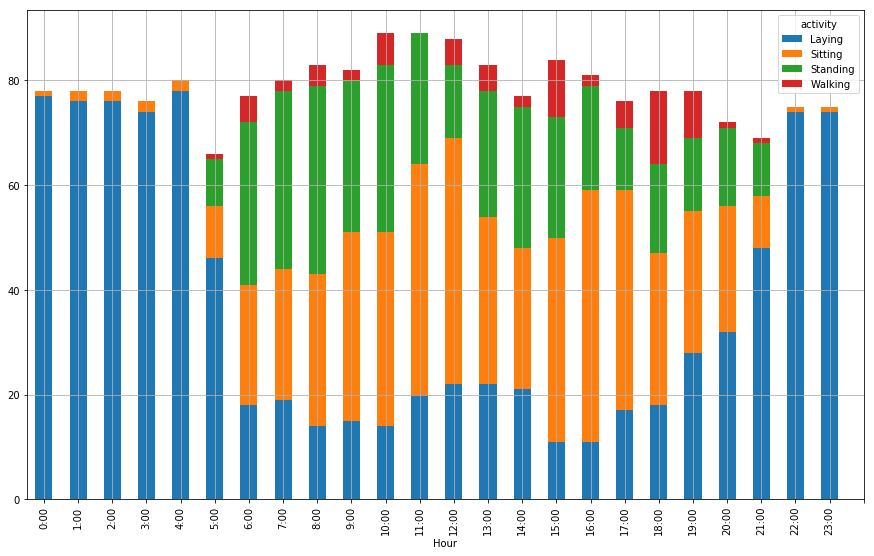

In [207]:
act_groups.unstack()['Steps'].plot(kind = "bar", stacked = True)
plt.xticks(np.arange(25), ['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', \
                          '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', \
                          '21:00', '22:00', '23:00'])
plt.grid()